Dataset in Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping the data

In [ ]:
!unzip "/content/drive/MyDrive/archive.zip"

In [3]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard


import cv2
import time
import itertools
import random

from sklearn.utils import shuffle
import seaborn as sn
import pandas as pd

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.utils.vis_utils import plot_model

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
# Checking Keras version
import keras
print(keras.__version__)

2.5.0


In [5]:
# Mapping dev to GPU
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [6]:
# Path to Hindi and Bengali datasets (Comment the one you don't need)
path = "/content/BHSig260/Hindi/"
#path = "/content/BHSig260/Bengali/"

In [7]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]  # next(os.walk(path)) returns a tuple ('path', [dir list], [.txt and otr files])
dir_list.sort()

In [8]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored i the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [9]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(160, 160)

In [10]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [11]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [12]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


In [13]:
# Data split for both Hindi and Bengali dataset (Comment the one you don't need)

# For Hindi
orig_train, orig_val, orig_test = orig_groups[:120], orig_groups[120:140], orig_groups[140:]
forg_train, forg_val, forg_test = forg_groups[:120], forg_groups[120:140], forg_groups[140:]

# For Bengali
#orig_train, orig_val, orig_test = orig_groups[:70], orig_groups[70:85], orig_groups[85:]
#forg_train, forg_val, forg_test = forg_groups[:70], forg_groups[70:85], forg_groups[85:]

In [14]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [15]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

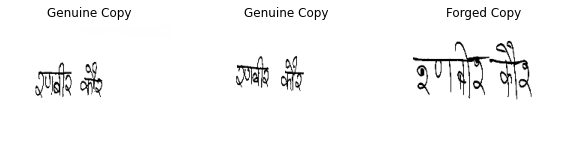

In [16]:
visualize_sample_signature()

In [17]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 288 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.

        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120 [HINDI]
        # Total number of Genuine-Forged pairs = 120 * 288 = 34560 [HINDI]
        # Total no. of data points = 33120 + 34560 = 67680 [HINDI]

        # Total no. of Genuine-Genuine pairs = 70 * 276 = 19320 [BENGALI]
        # Total number of Genuine-Forged pairs = 70 * 288 = 20160 [BENGALI]
        # Total no. of data points = 19320 + 20160 = 39480 [BENGALI]
        
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [18]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [19]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [20]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

**SigNet**

In [71]:
def Signet(input_shape):

    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform'))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    
    return seq

**SmallCNN**

*Avani Rateria and Suneeta Agarwal. Off-line signature verification through machine learning. In2018 5th IEEE Uttar Pradesh Section International Conference on Electrical, Electronics andComputer Engineering (UPCON), pages 1–7. IEEE, 2018.*

In [22]:
def SmallCNN(input_shape):

    seq = Sequential()

    seq.add(Conv2D(40, kernel_size=(5, 5), activation='relu', name='conv_1', strides=1, input_shape= input_shape))
    seq.add(MaxPooling2D((2,2), strides=(2, 2)))    
    seq.add(Conv2D(30, kernel_size=(3, 3), activation='relu', name='conv_2', strides=1))
    seq.add(Conv2D(20, kernel_size=(3, 3), activation='relu', name='conv_3', strides=1))

    seq.add(Flatten(name='flatten'))
    
    seq.add(Dense(20, activation='relu'))
    return seq

**CustomNET** (Self-made model)

In [23]:
def customNET(input_shape):

    seq = Sequential()

    seq.add(Conv2D(69, kernel_size=(10, 10), activation='relu', name='conv1_1', strides=2, input_shape= input_shape, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)) 

    seq.add(Conv2D(49, kernel_size=(5, 5), activation='relu', name='conv1_2', strides=2, input_shape= input_shape, kernel_initializer='glorot_uniform'))  
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))

    seq.add(Conv2D(29, kernel_size=(3, 3), activation='relu', name='conv1_3', strides=2, input_shape= input_shape, kernel_initializer='glorot_uniform'))  
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))

    seq.add(Flatten(name='flatten'))

    seq.add(Dense(12, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    return seq

In [72]:
# input image shape
input_shape=(img_h, img_w, 1)

In [73]:
# Creating the base network
# Comment out the network to be used

base_network = Signet(input_shape)
#base_network = SmallCNN(input_shape)
#base_network = CustomNET(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# Because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [74]:
# Calculating the sample sizes - Comment the dataset which is not being used

# Hindi
batch_sz = 128
num_train_samples = 276*120 + 288*120
num_val_samples = num_test_samples = 276*20 + 288*20
num_train_samples, num_val_samples, num_test_samples

# Bengali
#batch_sz = 128
#num_train_samples = 276*70 + 288*70
#num_val_samples = num_test_samples = 276*15 + 288*15
#num_train_samples, num_val_samples, num_test_samples

(67680, 11280, 11280)

In [75]:
# Compile model using RMSProp Optimizer and Contrastive loss function for SigNet and CustomCNN 
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [ ]:
# Compile model using Adam Optimizer and Contrastive loss function for SmallCNN
adam = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=adam)

In [76]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 10 epochs
callbacks = [
    EarlyStopping(monitor='val_loss',patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir='logs', write_graph=True, update_freq='epoch'),
    ModelCheckpoint('./Weights.h5', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
]

In [ ]:
# Network plot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [78]:
# Installing Visualkeras (Pictorial representation of the network)
%pip install visualkeras

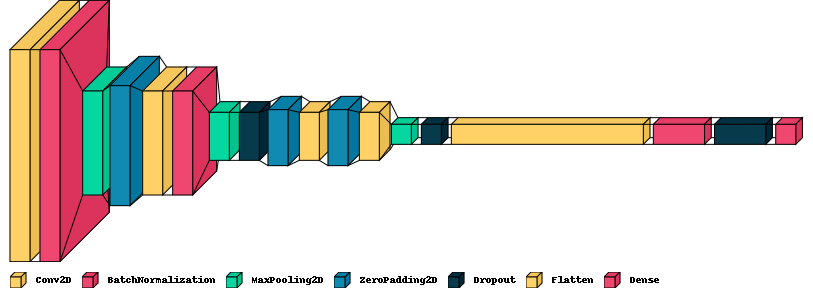

In [79]:
import visualkeras
visualkeras.layered_view(base_network, legend=True, scale_xy=4, scale_z=0.05, to_file='network_struct.png')

In [ ]:
# Calling the Tensorboard
%tensorboard --logdir logs

**Training and Validation**

In [ ]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

**Testing**

In [81]:
# Function to compute accuracy
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
     
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
       
        if (acc > max_acc):
            max_acc, best_thresh, best_tpr, best_tnr = acc, d, tpr, tnr
           
    return max_acc, best_thresh, best_tpr, best_tnr

In [82]:
# Loading the best weights to the model
model.load_weights('./Weights.h5')

In [83]:
# Testing
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i, j in enumerate(range(num_test_samples)):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [ ]:
# Accuracy, Threshold, TPR & TNR (Best) 
tr_acc, threshold, best_tpr, best_tnr = compute_accuracy_roc(np.array(pred), np.array(tr_y))
print("Accuracy: ", tr_acc, "\nThreshold: ", threshold, "\nTPR: ", best_tpr,"\nTNR: ", best_tnr)

In [87]:
# Predict distance score and classify test images as Genuine or Forged
def predict_score():
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

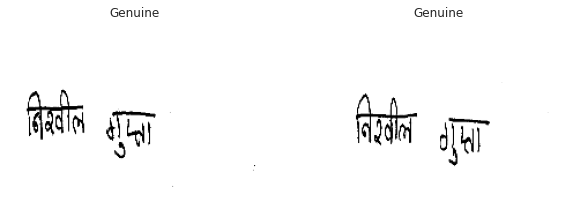

Difference Score =  0.029860467
Its a Genuine Signature


In [88]:
predict_score()

**Plotting**

In [ ]:
# Loss plot
plt.plot(range(len(results.history['loss'])), results.history['loss'], label="tr_loss")
plt.plot(range(len(results.history['val_loss'])), results.history['val_loss'], label="val_loss")
plt.plot(range(len(results.history[ 'lr'])), results.history['lr'], label="learning rate")

plt.xlabel("Epochs")
plt.legend()
plt.grid(True)
plt.savefig("lossplot.png",dpi=300)
plt.show()

In [ ]:
# Confusion Matrix
# Gen-Forged pair (0) 
# Gen-Gen pair (1) 

orig_labels = np.array(tr_y)
pred_labels = np.array(pred)
TP, TN, FP, FN = 0, 0, 0, 0

for i, j in zip(orig_labels, pred_labels):
  if i[0]==0 and j>=threshold:
    TN+=1
  if i[0]==0 and j<threshold:
    FP+=1
  if i[0]==1 and j<threshold:
    TP+=1
  if i[0]==1 and j>=threshold:
    FN+=1

array = [[TP,FP],
         [FN,TN]]

df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(dpi=150)
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='g', xticklabels=['1 (actual)','0 (actual)'], yticklabels=['1 (pred)','0 (pred)'])
plt.savefig("confmat.png",dpi=300)
plt.show()